# Handling MAIAC files in Python

### After downloading the data you need to convert the data from the HDF-EOS to GeoTIFF format as the MCD19A2 data is provided in sinosodial projection which is needed to be converted to geographic projection for which it is ideal to use NASA tool "HDF-EOS to GeoTIFF Conversion Tool (HEG)".

#### Loading the raster files data for 01/12/2018 and 09/12/2018 for band 1 of SDS field Optical_Depth_055 which is AOD at 550nm often used for extraction of Particulate matter in conjuction with other data depending on model used.

In [2]:
import georasters as gr
raster = 'D:/gis_files/Blank_raster/Dec9.tif'
raster2 = 'D:/gis_files/Blank_raster/Dec1.tif'
data = gr.from_file(raster)
data2 = gr.from_file(raster2)

#### Please note that i have clipped the raster for delhi extent from the tile h24v06 of MAIAC using the qgis Raster extration clipper. We can do it in python too using GDAL however it is complex. For refernce please visit- https://www.geos.ed.ac.uk/~smudd/TopoTutorials/html/tutorial_raster_conversion.html 

#### Checking the clipped raster output

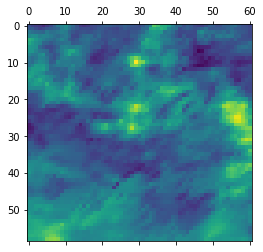

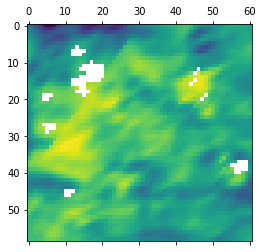

In [3]:
%matplotlib inline
data.plot()
data2.plot()

#### To perform operations over the raster we need to convert it into tabular format so we can easliy merge multiple rasters (in case of averaging)and calculate the statistics. So, changing the rasters to pandas dataframe is most useful.

In [4]:
df = data.to_pandas()
df2 = data2.to_pandas()
df.head()

,row,col,value,x,y
0,0,0,515,76.834534,28.891667
1,0,1,486,76.842868,28.891667
2,0,2,475,76.851201,28.891667
3,0,3,462,76.859534,28.891667
4,0,4,437,76.867868,28.891667


In [5]:
df2.rename(columns={'row':'row1',
                          'col':'col1',
                          'x':'x1',
                        'y':'y1',
                           'value':'value1'}, 
                 inplace=True)
df2.head()

,row1,col1,value1,x1,y1
0,0,0,226.0,76.834534,28.891667
1,0,1,215.0,76.842868,28.891667
2,0,2,191.0,76.851201,28.891667
3,0,3,173.0,76.859534,28.891667
4,0,4,139.0,76.867868,28.891667


#### Now that we have both data saved in form of pandas dataframe we can easily merge them

In [6]:
import pandas as pd
result = pd.concat([df, df2], axis=1, sort=False)
result.head()

,row,col,value,x,y,row1,col1,value1,x1,y1
0,0,0,515,76.834534,28.891667,0.0,0.0,226.0,76.834534,28.891667
1,0,1,486,76.842868,28.891667,0.0,1.0,215.0,76.842868,28.891667
2,0,2,475,76.851201,28.891667,0.0,2.0,191.0,76.851201,28.891667
3,0,3,462,76.859534,28.891667,0.0,3.0,173.0,76.859534,28.891667
4,0,4,437,76.867868,28.891667,0.0,4.0,139.0,76.867868,28.891667


#### Dropping the repeated columns to make the dataframe clean

In [7]:
result = result.drop(columns=['x1', 'y1','row1','col1'])

In [8]:
result.head()

,row,col,value,x,y,value1
0,0,0,515,76.834534,28.891667,226.0
1,0,1,486,76.842868,28.891667,215.0
2,0,2,475,76.851201,28.891667,191.0
3,0,3,462,76.859534,28.891667,173.0
4,0,4,437,76.867868,28.891667,139.0


#### Taking average of two rasters or columns in this case

In [9]:
result['avg'] = (result['value']+result['value1'])/2

#### Checking the average of two rasters

In [10]:
result.tail()

,row,col,value,x,y,value1,avg
3594,58,56,692,77.301201,28.408333,NaN,NaN
3595,58,57,697,77.309534,28.408333,NaN,NaN
3596,58,58,716,77.317868,28.408333,NaN,NaN
3597,58,59,697,77.326201,28.408333,NaN,NaN
3598,58,60,658,77.334534,28.408333,NaN,NaN


#### Checking the statics of the two rasters

In [11]:
result.describe()

,row,col,value,x,y,value1,avg
count,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3508.000000,3508.000000
mean,29.000000,30.000000,604.557099,77.084534,28.650000,312.505131,457.470068
std,17.031753,17.609263,94.481370,0.146744,0.141931,48.748942,53.134761
min,0.000000,0.000000,355.000000,76.834534,28.408333,107.000000,288.000000
25%,14.000000,15.000000,532.000000,76.959534,28.525000,283.000000,422.500000
50%,29.000000,30.000000,596.000000,77.084534,28.650000,313.000000,453.500000
75%,44.000000,45.000000,665.000000,77.209534,28.775000,345.000000,490.500000
max,58.000000,60.000000,1002.000000,77.334534,28.891667,434.000000,685.500000


#### Saving this file as csv for further analysis

In [12]:
result.to_csv("result_aod.csv",index=False)

#### Converting the table into netcdf format to directly import in ArcGIS or QGIS

In [13]:
file1 = open("raster_out.txt","w")
file1.write("NCOLS 61\n")
file1.write("NROWS 59\n")
file1.write("XLLCORNER 76.834534489\n")
file1.write("YLLCORNER 28.8916666638\n")
file1.write("CELLSIZE 0.0083333333\n")
file1.write("NODATA_VALUE -9999\n")
for i in range(0,59):
    for k in range(0,61):
        file1.write(str(result['avg'][i+k]))
        file1.write("\t")
    file1.write("\n")
file1.close()

#### After the above task is accomplished it is very easy to perform statistical operations and employing machine learning algorithm libraries to process the data as needed 

## Thank you for reading this far patiently